In [ ]:
pip install keras

In [ ]:
pip install tensorflow

In [ ]:
pip install xgboost

In [ ]:
pip install lightgbm

In [ ]:
pip install pandas

In [ ]:
pip install seaborn

In [ ]:
pip install statsmodels

In [ ]:
pip install -U scikit-learn

In [3]:
import json
import os
import csv
import collections
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import shutil
import time
from scipy.stats import zscore
from scipy import stats
from sklearn import preprocessing
from sklearn import utils
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

import io
import requests
from sklearn import metrics
from keras import optimizers
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import xgboost as xgb
import lightgbm as lgb

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, r2_score, roc_curve, auc

C:\ProgramData\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [4]:
# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32, np.object):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

    
# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)
df =pd.read_csv('C:/Users/HamzaPC/Desktop/Seminar/fifa.csv')


# Function to convert string values to numeric
import numpy as np

def convert_to_numeric(value):
    if pd.isna(value) or value == '':
        return 0
    elif isinstance(value, (int, float)):
        return float(value)
    elif 'M' in value:
        return float(value.replace('€', '').replace('M', '')) * 1e6
    elif 'K' in value:
        return float(value.replace('€', '').replace('K', '')) * 1e3
    else:
        return np.nan


# Apply the function to the 'Values' column
df['Value'] = df['Value'].apply(convert_to_numeric)
df['Wage'] = df['Wage'].apply(convert_to_numeric)

df.drop(['ID','Photo','Flag','Potential','Club Logo','Special','International Reputation','Weak Foot','Real Face','Jersey Number','Joined','Loaned From'
        ,'Contract Valid Until','LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM','RM','LWB','LDM'
         ,'CDM','RDM','RWB','LB','LCB','CB','RCB','RB','Release Clause','Work Rate'],axis=1,inplace=True)

#Here we have to change the empty values 

df['Position'].fillna('ST', inplace = True)
df['Weight'].fillna('200lbs', inplace = True)
df['Height'].fillna("5'11", inplace = True)
df['Nationality'].fillna('Pakistani', inplace = True)
df['Body Type'].fillna('Normal', inplace = True)
df['Skill Moves'].fillna(df['Skill Moves'].median(), inplace = True)
df['Preferred Foot'].fillna('Right', inplace = True)

df.dropna(inplace = True)

In [5]:
#Variables for Pandas
df_DRLR = df.copy()
df_LR = df.copy()
df_DRRF = df.copy()

RMSE: 4.731960885443479
R-squared: 0.5285432974655184
ATT: 9.2914639983235
Accuracy: 0.07816862088218872


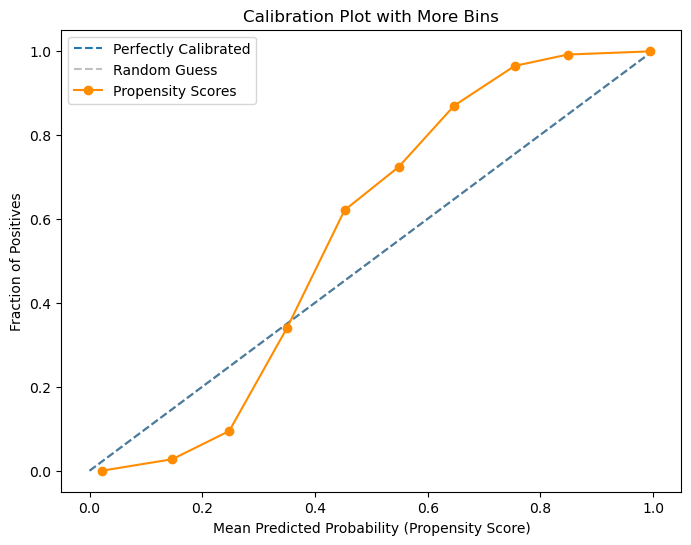

Standardized Bias for Wage: 1.3266587759227335
Standardized Bias for Age: 0.5404468565531112
Standardized Bias for Value: 1.0923831128560166


In [6]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_LR is your DataFrame
# Select relevant columns for logistic regression modeling
logistic_cols = ['Wage', 'Age', 'Value', 'Overall']

# Create the feature matrix X and target variable y for logistic regression modeling
X_logistic = df_LR[logistic_cols].dropna().drop('Overall', axis=1)
y_logistic = (df_LR['Overall'] > df_LR['Overall'].median()).astype(int)

# Fit a Logistic Regression model for propensity modeling
logistic_model = LogisticRegression()
logistic_model.fit(X_logistic, y_logistic)

# Obtain predicted probabilities for each observation
df_LR['PropensityScore'] = logistic_model.predict_proba(X_logistic)[:, 1]

# Select relevant columns for linear regression modeling
cols_for_modeling = ['Wage', 'Age', 'Value', 'Overall']

# Create feature matrix X and target variable y for linear regression modeling
X = df_LR[cols_for_modeling].dropna().drop('Overall', axis=1)
y = df_LR['Overall'].dropna()

# Split the data into training and testing sets for linear regression modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create a new column indicating treatment status
df_LR['Treated'] = (df_LR['Wage'] > df_LR['Wage'].median()).astype(int)

# Assuming 'PropensityScore' is a column in your DataFrame containing propensity scores
# Use this column as a weight for linear regression
weights = df_LR['PropensityScore']

# Fit a weighted linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train, sample_weight=weights[X_train.index])

# Predict the outcome on the test set
y_pred = lr_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE:', rmse)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print('R-squared:', r_squared)

# Calculate ATT using stratification
att_by_quintile = df_LR.groupby('Treated')['Overall'].mean().diff().iloc[1]
print('ATT:', att_by_quintile)

# Calculate Accuracy (optional)
accuracy_linear = accuracy_score(y_test, y_pred.round())
print('Accuracy:', accuracy_linear)





# Assuming df_LR is your DataFrame
# Select relevant columns for propensity modeling
propensity_cols = ['Wage', 'Age', 'Value', 'Overall']

# Create the feature matrix X and target variable y for propensity modeling
X_propensity = df_LR[propensity_cols].dropna().drop('Overall', axis=1)
y_propensity = (df_LR['Overall'] > df_LR['Overall'].median()).astype(int)

# Standardize numerical variables (optional but can be beneficial)
scaler = StandardScaler()
X_propensity[['Wage', 'Age', 'Value']] = scaler.fit_transform(X_propensity[['Wage', 'Age', 'Value']])

# Split the data into training and testing sets for propensity modeling
X_train_propensity, X_test_propensity, y_train_propensity, y_test_propensity = train_test_split(
    X_propensity, y_propensity, test_size=0.2, random_state=1
)


propensity_model = LogisticRegression()
propensity_model.fit(X_train_propensity, y_train_propensity)

# Obtain predicted probabilities for each observation in the test set
y_pred_propensity = propensity_model.predict_proba(X_test_propensity)[:, 1]

# Calibration Plot with More Bins
plt.figure(figsize=(8, 6))
prob_true, prob_pred = calibration_curve(y_test_propensity, y_pred_propensity, n_bins=10, strategy='uniform')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.5, label='Random Guess')
plt.plot(prob_pred, prob_true, marker='o', label='Propensity Scores', color='darkorange')
plt.xlabel('Mean Predicted Probability (Propensity Score)')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot with More Bins')
plt.legend(loc='upper left')
plt.show()



import pandas as pd

# Calculate Standardized Bias for 'Wage', 'Age', and 'Value'
def calculate_standardized_bias(df, covariate, treatment_column, propensity_score_column):
    treated_group = df[df[treatment_column] == 1]
    control_group = df[df[treatment_column] == 0]

    mean_treated = treated_group[covariate].mean()
    mean_control = control_group[covariate].mean()

    std_treated = treated_group[covariate].std()
    std_control = control_group[covariate].std()

    propensity_weighted_mean_treated = (treated_group[covariate] * treated_group[propensity_score_column]).sum() / treated_group[propensity_score_column].sum()
    propensity_weighted_mean_control = (control_group[covariate] * control_group[propensity_score_column]).sum() / control_group[propensity_score_column].sum()

    standardized_bias = (propensity_weighted_mean_treated - propensity_weighted_mean_control) / ((std_treated + std_control) / 2)

    return standardized_bias

# Calculate Standardized Bias for 'Wage'
standardized_bias_wage = calculate_standardized_bias(df_LR, 'Wage', 'Treated', 'PropensityScore')

# Calculate Standardized Bias for 'Age'
standardized_bias_age = calculate_standardized_bias(df_LR, 'Age', 'Treated', 'PropensityScore')

# Calculate Standardized Bias for 'Value'
standardized_bias_value = calculate_standardized_bias(df_LR, 'Value', 'Treated', 'PropensityScore')

# Print the results
print(f'Standardized Bias for Wage: {standardized_bias_wage}')
print(f'Standardized Bias for Age: {standardized_bias_age}')
print(f'Standardized Bias for Value: {standardized_bias_value}')



In [5]:
#Doubly Robust (DR) with Logistic Regression (LR)

In [6]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, roc_auc_score, f1_score
from sklearn.ensemble import GradientBoostingRegressor


# Select relevant columns for DR modeling
dr_cols = ['Wage', 'Age', 'Value', 'Overall']

# Create the feature matrix X and target variable y
X_dr = df_DRLR[dr_cols].dropna().drop('Overall', axis=1)
y_dr = df_DRLR['Overall']
treat_dr = (df_DRLR['Wage'] > df_DRLR['Wage'].median()).astype(int)

# Split the data into training and testing sets
X_train_dr, X_test_dr, y_train_dr, y_test_dr, treat_train_dr, treat_test_dr = train_test_split(
    X_dr, y_dr, treat_dr, test_size=0.2, random_state=1
)

# Fit logistic regression for treatment propensity
propensity_model_dr = LogisticRegression()
propensity_model_dr.fit(X_train_dr, treat_train_dr)

# Predict treatment probabilities on the test set
propensity_scores_dr = propensity_model_dr.predict_proba(X_test_dr)[:, 1]

# Standardize numerical variables (optional but can be beneficial)
scaler_dr = StandardScaler()
X_train_std_dr = scaler_dr.fit_transform(X_train_dr)
X_test_std_dr = scaler_dr.transform(X_test_dr)

# Fit outcome regression model (can be any model suitable for your data)
outcome_model_dr = GradientBoostingRegressor()
outcome_model_dr.fit(X_train_std_dr, y_train_dr)

# Predict the potential outcomes under treatment and control
y_treated_dr = outcome_model_dr.predict(X_test_std_dr)
y_control_dr = outcome_model_dr.predict(X_test_std_dr)

# Add the 'Treated' column to df_DRLR
df_DRLR.loc[X_test_dr.index, 'Treated'] = treat_test_dr.values


# Calculate the doubly robust treatment effect estimate
dr_estimate = np.mean(treat_test_dr * (y_test_dr - y_treated_dr) / propensity_scores_dr +
                      (1 - treat_test_dr) * (y_treated_dr - y_test_dr) / (1 - propensity_scores_dr))

# Print the Doubly Robust treatment effect estimate
print(f"Doubly Robust Treatment Effect Estimate: {dr_estimate}")

# Check for accuracy (optional)
treat_pred_dr = propensity_scores_dr > 0.5  # Adjust threshold as needed
accuracy_dr = accuracy_score(treat_test_dr, treat_pred_dr)
print(f"Accuracy of Propensity Model: {accuracy_dr}")

# Calculate mean outcomes for treated and untreated groups
mean_outcome_treated = df_DRLR[df_DRLR['Treated'] == 1]['Overall'].mean()
mean_outcome_untreated = df_DRLR[df_DRLR['Treated'] == 0]['Overall'].mean()

# Calculate ATT
ATT_DRLR = mean_outcome_treated - mean_outcome_untreated
print('Average Treatment Effect on the Treated (ATT) for DRLR:', ATT_DRLR)

# Calculate RMSE
rmse = mean_squared_error(y_test_dr, y_treated_dr, squared=False)
print('RMSE:', rmse)

# Calculate R-squared
r_squared = r2_score(y_test_dr, y_treated_dr)
print('R-squared:', r_squared)

# Calculate AUC-ROC Score
auc_roc = roc_auc_score(treat_test_dr, propensity_scores_dr)
print('AUC-ROC Score:', auc_roc)

# Check for accuracy (optional)
treat_pred_dr = propensity_scores_dr > 0.5  # Adjust threshold as needed
accuracy_dr = accuracy_score(treat_test_dr, treat_pred_dr)
print(f"Accuracy of Propensity Model: {accuracy_dr}")

# Calculate F1 Score
f1 = f1_score(treat_test_dr, treat_pred_dr)
print('F1 Score:', f1)



# Calculate mean and standard deviation for treated and untreated groups
mean_treated = df_DRLR[df_DRLR['Treated'] == 1][['Wage', 'Age', 'Value']].mean()
mean_untreated = df_DRLR[df_DRLR['Treated'] == 0][['Wage', 'Age', 'Value']].mean()

std_treated = df_DRLR[df_DRLR['Treated'] == 1][['Wage', 'Age', 'Value']].std()
std_untreated = df_DRLR[df_DRLR['Treated'] == 0][['Wage', 'Age', 'Value']].std()

# Calculate Standardized Bias
standardized_bias_wage = (mean_treated['Wage'] - mean_untreated['Wage']) / np.sqrt((std_treated['Wage']**2 + std_untreated['Wage']**2) / 2)
standardized_bias_age = (mean_treated['Age'] - mean_untreated['Age']) / np.sqrt((std_treated['Age']**2 + std_untreated['Age']**2) / 2)
standardized_bias_value = (mean_treated['Value'] - mean_untreated['Value']) / np.sqrt((std_treated['Value']**2 + std_untreated['Value']**2) / 2)

print(f'Standardized Bias for Wage: {standardized_bias_wage}')
print(f'Standardized Bias for Age: {standardized_bias_age}')
print(f'Standardized Bias for Value: {standardized_bias_value}')

Doubly Robust Treatment Effect Estimate: 0.0045843523145044545
Accuracy of Propensity Model: 0.47292015633724177
Average Treatment Effect on the Treated (ATT) for DRLR: 9.006549066965249
RMSE: 0.8031976827935245
R-squared: 0.9864167274196293
AUC-ROC Score: 0.9970706336281963
Accuracy of Propensity Model: 0.47292015633724177
F1 Score: 0.6339666537417603
Standardized Bias for Wage: 0.7540729940569538
Standardized Bias for Age: 0.5663097604540269
Standardized Bias for Value: 0.6794088207319957


In [7]:
#Doubly Robust Random Forest

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Assuming df_DRRF is your DataFrame
df_DRRF['Value'] = df_DRRF['Value'].apply(pd.to_numeric, errors='coerce')
df_DRRF['Wage'] = df_DRRF['Wage'].apply(pd.to_numeric, errors='coerce')

# Select relevant columns for DR-RF modeling
dr_rf_cols = ['Wage', 'Age', 'Value', 'Overall']

# Create the feature matrix X and target variable y
X_dr_rf = df_DRRF[dr_rf_cols].dropna().drop('Overall', axis=1)
y_dr_rf = df_DRRF['Overall']
treat_dr_rf = (df_DRRF['Wage'] > df_DRRF['Wage'].median()).astype(int)

# Split the data into training and testing sets
X_train_dr_rf, X_test_dr_rf, y_train_dr_rf, y_test_dr_rf, treat_train_dr_rf, treat_test_dr_rf = train_test_split(
    X_dr_rf, y_dr_rf, treat_dr_rf, test_size=0.2, random_state=1
)

# Fit logistic regression for treatment propensity
propensity_model_dr_rf = LogisticRegression()
propensity_model_dr_rf.fit(X_train_dr_rf, treat_train_dr_rf)

# Predict treatment probabilities on the test set
propensity_scores_dr_rf = propensity_model_dr_rf.predict_proba(X_test_dr_rf)[:, 1]

# Standardize numerical variables (optional but can be beneficial)
scaler_dr_rf = StandardScaler()
X_train_std_dr_rf = scaler_dr_rf.fit_transform(X_train_dr_rf)
X_test_std_dr_rf = scaler_dr_rf.transform(X_test_dr_rf)

# Fit outcome regression model (Random Forest)
outcome_model_dr_rf = RandomForestRegressor(n_estimators=100, random_state=1)
outcome_model_dr_rf.fit(X_train_std_dr_rf, y_train_dr_rf)

# Predict the potential outcomes under treatment and control
y_treated_dr_rf = outcome_model_dr_rf.predict(X_test_std_dr_rf)
y_control_dr_rf = outcome_model_dr_rf.predict(X_test_std_dr_rf)

# Calculate the doubly robust treatment effect estimate
dr_estimate_rf = np.mean(treat_test_dr_rf * (y_test_dr_rf - y_treated_dr_rf) / propensity_scores_dr_rf +
                         (1 - treat_test_dr_rf) * (y_treated_dr_rf - y_test_dr_rf) / (1 - propensity_scores_dr_rf))

# Print the Doubly Robust treatment effect estimate
print(f"Doubly Robust Treatment Effect Estimate (Random Forest): {dr_estimate_rf}")

# Check for accuracy (optional)
treat_pred_dr_rf = propensity_scores_dr_rf > 0.5  # Adjust threshold as needed
accuracy_dr_rf = accuracy_score(treat_test_dr_rf, treat_pred_dr_rf)
print(f"Accuracy of Propensity Model (Random Forest): {accuracy_dr_rf}")

# Assuming df_DRRF is your DataFrame with the Doubly Robust Random Forest results
df_DRRF['Wage'] = df_DRRF['Wage'].apply(pd.to_numeric, errors='coerce')

# Create a new column indicating treatment status
df_DRRF['Treated'] = (df_DRRF['Wage'] > df_DRRF['Wage'].median()).astype(int)

# Calculate mean outcomes for treated and untreated groups
mean_outcome_treated_rf = df_DRRF[df_DRRF['Treated'] == 1]['Overall'].mean()
mean_outcome_untreated_rf = df_DRRF[df_DRRF['Treated'] == 0]['Overall'].mean()

# Calculate ATT
ATT_DRRF = mean_outcome_treated_rf - mean_outcome_untreated_rf

print('Average Treatment Effect on the Treated (ATT) for DR-RF:', ATT_DRRF)

# Evaluate model performance
y_pred_dr_rf = outcome_model_dr_rf.predict(X_test_std_dr_rf)
rmse_dr_rf = np.sqrt(mean_squared_error(y_test_dr_rf, y_pred_dr_rf))
r2_dr_rf = r2_score(y_test_dr_rf, y_pred_dr_rf)

print('RMSE:', rmse_dr_rf)
print('R-squared:', r2_dr_rf)

# Assuming df_DRRF is your DataFrame with the Doubly Robust Treatment Effect Estimate
df_DRRF['Treated'] = (df_DRRF['Wage'] > df_DRRF['Wage'].median()).astype(int)

# Calculate mean outcomes for treated and untreated groups
mean_outcome_treated_rf = df_DRRF[df_DRRF['Treated'] == 1]['Overall'].mean()
mean_outcome_untreated_rf = df_DRRF[df_DRRF['Treated'] == 0]['Overall'].mean()

# Calculate ATT
ATT_DRRF = mean_outcome_treated_rf - mean_outcome_untreated_rf

print('Average Treatment Effect on the Treated (ATT) for DR-RF:', ATT_DRRF)

# Calculate predicted probabilities from the Doubly Robust Random Forest model
propensity_scores_rf = propensity_model_dr_rf.predict_proba(X_test_dr_rf)[:, 1]

# Calculate F1 score
f1_rf = f1_score(treat_test_dr_rf, treat_pred_dr_rf)
print(f"F1 Score: {f1_rf}")

# Calculate AUC-ROC
roc_auc_rf = roc_auc_score(treat_test_dr_rf, propensity_scores_rf)
print(f"AUC-ROC Score: {roc_auc_rf}")

# Calculate Standardized Bias for Age, Wage, and Value
mean_age_treated_rf = df_DRRF[df_DRRF['Treated'] == 1]['Age'].mean()
mean_age_untreated_rf = df_DRRF[df_DRRF['Treated'] == 0]['Age'].mean()

mean_wage_treated_rf = df_DRRF[df_DRRF['Treated'] == 1]['Wage'].mean()
mean_wage_untreated_rf = df_DRRF[df_DRRF['Treated'] == 0]['Wage'].mean()

mean_value_treated_rf = df_DRRF[df_DRRF['Treated'] == 1]['Value'].mean()
mean_value_untreated_rf = df_DRRF[df_DRRF['Treated'] == 0]['Value'].mean()

std_bias_age_rf = (mean_age_treated_rf - mean_age_untreated_rf) / np.sqrt(df_DRRF['Age'].var())
std_bias_wage_rf = (mean_wage_treated_rf - mean_wage_untreated_rf) / np.sqrt(df_DRRF['Wage'].var())
std_bias_value_rf = (mean_value_treated_rf - mean_value_untreated_rf) / np.sqrt(df_DRRF['Value'].var())

# Print Standardized Bias values
print(f'Standardized Bias for Age: {std_bias_age_rf}')
print(f'Standardized Bias for Wage: {std_bias_wage_rf}')
print(f'Standardized Bias for Value: {std_bias_value_rf}')




Doubly Robust Treatment Effect Estimate (Random Forest): 0.014234074255987607
Accuracy of Propensity Model (Random Forest): 0.47292015633724177
Average Treatment Effect on the Treated (ATT) for DR-RF: 9.2914639983235
RMSE: 0.7770074172756861
R-squared: 0.9872881180435376
Average Treatment Effect on the Treated (ATT) for DR-RF: 9.2914639983235
F1 Score: 0.6339666537417603
AUC-ROC Score: 0.9970706336281963
Standardized Bias for Age: 0.5388252413419764
Standardized Bias for Wage: 0.7918166783134486
Standardized Bias for Value: 0.7125300004056877


In [9]:
#Naive Bayes

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# Assuming df is your DataFrame with 'Wage', 'Overall', 'Age', 'Value'

# Create a new column indicating treatment status
df['Treated'] = (df['Wage'] > df['Wage'].median()).astype(int)

# Naive comparison of outcomes between treated and untreated groups
treated_group = df[df['Treated'] == 1]['Overall']
untreated_group = df[df['Treated'] == 0]['Overall']

# Perform t-test for comparison
t_statistic, p_value = ttest_ind(treated_group, untreated_group, equal_var=False)

# Calculate average treatment effect (Naive)
att_naive = treated_group.mean() - untreated_group.mean()

# Calculate efficiency
efficiency = 1 / (1 + p_value)

# Create a dummy prediction (the mean of the treated group)
naive_prediction = np.full_like(df['Overall'], treated_group.mean())

# Calculate accuracy (assuming a binary classification problem, e.g., threshold at the median)
naive_accuracy = accuracy_score(df['Treated'], (df['Overall'] > df['Overall'].median()).astype(int))

# Calculate RMSE
naive_rmse = np.sqrt(mean_squared_error(df['Overall'], naive_prediction))

# Calculate R-squared
naive_r_squared = r2_score(df['Overall'], naive_prediction)

# Print the results
print(f"T-Test Statistic: {t_statistic}, p-value: {p_value}")
print(f"Average Treatment Effect (Naive): {att_naive}")
print(f"Efficiency: {efficiency}")
print(f"Accuracy: {naive_accuracy}")
print(f"RMSE: {naive_rmse}")
print(f"R-squared: {naive_r_squared}")


T-Test Statistic: 120.49146457526845, p-value: 0.0
Average Treatment Effect (Naive): 9.2914639983235
Efficiency: 1.0
Accuracy: 0.8393365722901659
RMSE: 8.404748994621437
R-squared: -0.4723336795438813


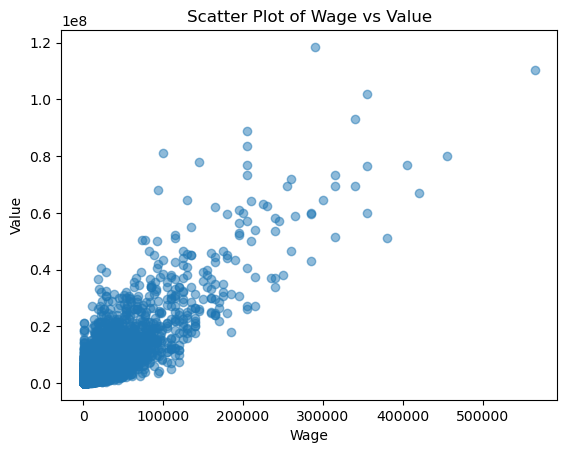

Correlation Coefficient between Wage and Value: 0.8580368208808768


In [11]:




import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'Variable1' and 'Variable2' with the actual column names in your DataFrame
variable1 = df['Wage']
variable2 = df['Value']

# Calculate correlation coefficient
correlation_coefficient = variable1.corr(variable2)

# Visualize the relationship with a scatter plot
plt.scatter(variable1, variable2, alpha=0.5)
plt.title('Scatter Plot of Wage vs Value')
plt.xlabel('Wage')
plt.ylabel('Value')
plt.show()

# Print the correlation coefficient
print(f"Correlation Coefficient between Wage and Value: {correlation_coefficient}")


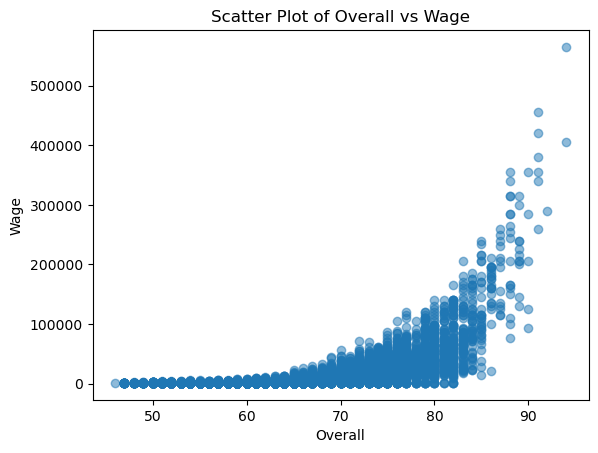

Correlation Coefficient between Overall and Wage: 0.5760982283736236


In [12]:




import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'Variable1' and 'Variable2' with the actual column names in your DataFrame
variable1 = df['Overall']
variable2 = df['Wage']

# Calculate correlation coefficient
correlation_coefficient = variable1.corr(variable2)

# Visualize the relationship with a scatter plot
plt.scatter(variable1, variable2, alpha=0.5)
plt.title('Scatter Plot of Overall vs Wage')
plt.xlabel('Overall')
plt.ylabel('Wage')
plt.show()

# Print the correlation coefficient
print(f"Correlation Coefficient between Overall and Wage: {correlation_coefficient}")


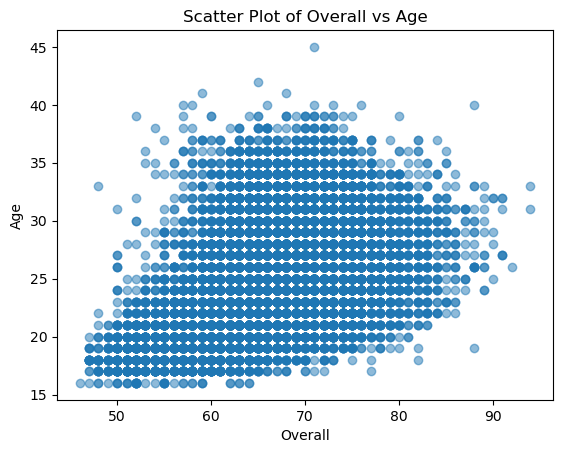

Correlation Coefficient between Overall and Age: 0.45661885009586617


In [13]:




import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Replace 'Variable1' and 'Variable2' with the actual column names in your DataFrame
variable1 = df['Overall']
variable2 = df['Age']

# Calculate correlation coefficient
correlation_coefficient = variable1.corr(variable2)

# Visualize the relationship with a scatter plot
plt.scatter(variable1, variable2, alpha=0.5)
plt.title('Scatter Plot of Overall vs Age')
plt.xlabel('Overall')
plt.ylabel('Age')
plt.show()

# Print the correlation coefficient
print(f"Correlation Coefficient between Overall and Age: {correlation_coefficient}")
